In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.data import TFRecordDataset
from tensorflow.keras import datasets, layers, models, losses, callbacks

2024-03-25 20:31:57.962459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 20:31:57.962503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 20:31:57.964101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 20:31:57.972653: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 20:31:59.368911: W tensorflow/compiler/tf2

In [2]:
MODEL_NAME = "./treino/primeiro_treino"
PASTA_FOURIER = "data/fourier/"
SPS = 200

In [3]:
df = pd.read_csv('data/scores.csv')

In [4]:
df = df.sample(frac=1, random_state=200)

In [5]:
df_val = df.head(2700)
df_train = df.tail( df.shape[0]- 2700 )

In [6]:
def get_data(eeg):
    return np.load(PASTA_FOURIER+str(eeg)+".npy")


def get_start_end(row, pos, max_size):
    if pos == len(row['janelas']):
        return max_size, max_size

    j = row['janelas'].split(',')[0].split('-')
    return float(j[0])*2, float(j[1])*2

def score_data(row):
    data = get_data(row['eeg_id'])
    max_size = data.shape[0]
    scores = [] 
    j_pos = 0
    start, end = get_start_end(row, j_pos, max_size)

    for i in range(max_size):
        if end < i:
            j_pos += 1
            start, end = get_start_end(row, j_pos, max_size)

        if i >= start and i <= end:
            scores.append( [row['seizure_vote'],row['lpd_vote'],row['gpd_vote'],row['lrda_vote'],row['grda_vote'],row['other_vote'] ] )
        else:
            scores.append( [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] )


    return np.expand_dims(data, -1), scores


In [23]:
def get_scored_train_data():
    for i, row in df_train.iterrows():
        yield( score_data(row) )

def get_scored_val_data():
    for i, row in df_val.iterrows():
        yield( score_data(row) )


In [24]:
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4) 

# tf.compat.v1.disable_eager_execution()


# config = tf.compat.v1.ConfigProto() 
# config.gpu_options.allow_growth=True 
# sess = tf.compat.v1.Session(config=config) 


In [9]:
# reg = tf.keras.regularizers.L1L2(l1=1, l2=1)
# reg = tf.keras.regularizers.l1()
# reg = tf.keras.regularizers.L2(l2=0.00000001)
reg=None
act = "relu"

model = models.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation=act, kernel_regularizer=reg, input_shape=(20, 200, 1)))
model.add(layers.MaxPooling2D((2, 20)))
model.add(layers.Conv2D(32, (2, 2), activation=act, kernel_regularizer=reg))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation=act, kernel_regularizer=reg))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(500, activation=act, kernel_regularizer=reg))
model.add(layers.Dense(60, activation=act, kernel_regularizer=reg))
model.add(layers.Dense(6, activation='softmax'))

2024-03-25 20:32:00.731311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 20:32:00.798846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 20:32:00.799147: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
model=tf.keras.models.load_model(MODEL_NAME)

In [11]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 19, 199, 16)       80        
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 9, 9, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 32)          2080      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 4, 4, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 3, 3, 32)          4128      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 1, 1, 32)         

In [25]:
train_data = tf.data.Dataset.from_generator(
        get_scored_train_data,
        output_signature = (
            tf.TensorSpec(shape=(None, 20, 200, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float32)
        )
    )

val_data = tf.data.Dataset.from_generator(
        get_scored_val_data,
        output_signature = (
            tf.TensorSpec(shape=(None, 20, 200, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float32)
        )
    )

In [13]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy()
)

In [31]:

history = model.fit(
    train_data,
    epochs=10,
    # batch_size=1,
    steps_per_epoch=20,
    # shuffle=True,
    validation_data = val_data,
    validation_steps=20,
    verbose= 1,
    callbacks = [
        callbacks.EarlyStopping(monitor="val_loss", patience=2),
        callbacks.ModelCheckpoint(MODEL_NAME, save_best_only = True)
    ]
)

Epoch 1/10
 1/20 [>.............................] - ETA: 1s - loss: 1.9565

20/20 [==============================] - ETA: 0s - loss: 1.4586INFO:tensorflow:Assets written to: ./treino/primeiro_treino/assets


INFO:tensorflow:Assets written to: ./treino/primeiro_treino/assets


20/20 [==============================] - 2s 93ms/step - loss: 1.4586 - val_loss: 1.4796
Epoch 2/10
20/20 [==============================] - 1s 40ms/step - loss: 1.1901 - val_loss: 1.4848
Epoch 3/10


2024-03-25 20:34:53.149813: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB (rounded to 1205806336)requested by op gradient_tape/sequential_4/max_pooling2d_9/MaxPool/MaxPoolGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-25 20:34:53.149860: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-25 20:34:53.149880: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 64, Chunks in use: 63. 16.0KiB allocated for chunks. 15.8KiB in use in bin. 2.8KiB client-requested in use in bin.
2024-03-25 20:34:53.149896: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_4/max_pooling2d_9/MaxPool/MaxPoolGrad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_12474/2663133363.py", line 1, in <module>

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 598, in minimize

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 656, in _compute_gradients

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 532, in _get_gradients

OOM when allocating tensor with shape[4983,16,19,199] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_4/max_pooling2d_9/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2201]

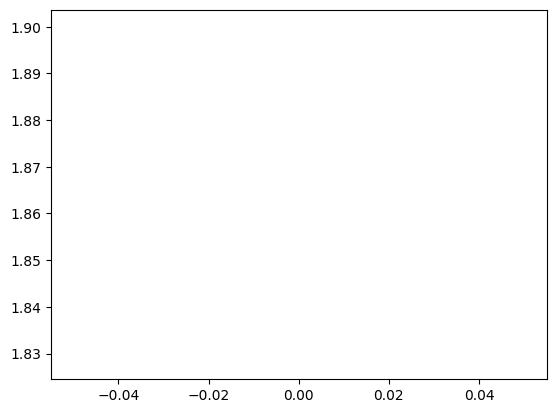

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='red')

In [16]:
i = get_scored_val_data()

In [17]:
x = next(i)

In [18]:
x[1][0]

[0.0, 0.0, 0.5384615384615384, 0.0, 0.1538461538461538, 0.3076923076923077]

In [19]:
model.predict( x[0] )

6/6 [==============================] - 1s 46ms/step


array([[0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       ...,
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ]], dtype=float32)

In [20]:
x = next(i)
x[1][0]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
model.predict( x[0] )

9/9 [==============================] - 0s 29ms/step


array([[0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       ...,
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ],
       [0.1557536 , 0.16032799, 0.12230641, 0.09464989, 0.14423737,
        0.3227247 ]], dtype=float32)